# Bitcoin Prediction with 5 Deep Learning Models
## APS 1052 Final Project 2021 Spring
 **Author:**
 
Dijia Zhang

Meiyun Xiao

Xiang Cao

**Date:** 23-Apr-2021

# Project Executive Summary: 
In this project, We compared 5 different deep learning models for prediction of Bitcoin Price. Those 5 models are mostly Recurrent Neural Network based that specialize in predicting sequential time series data. The original Bitcoin dataset is collected over the period from 2013-10-01 to 2020-10-09 with a total of 2556 samples and 16 features that tracks Bitcoin and financial market changes over time. We added a look back window of 20 days to the Bitcoin dataset and constructed a 3-dimensional time series data with temporal dimension to predict Bitcoin price on the 21st day. We evaluate 5 deep learning models on the dataset: **LSTM, RNN, WaveNet, Sequence-to-sequence LSTM and GRU+CNN**. Among those 5 models, the LSTM, RNN, and WaveNet are sequenc-to-vector models that output 1 prediction, while the other 2 models are sequqnce-to-sequence models that output a sequence of 4 predictions at each time step. 

We also did feature engineering by adding additional 8 different features including 5 Commodity Futures (COT) features and 3 related stock price features(Ticker: QQQ, FINX, RIOT). We compare the performance before and after adding the additioanl 8 features and found most deep learning model perform better with more related features. CAGR and Sharpe ratio is calculated with an only-long trading strategy based on the model prediction. After calculating White's reality check, most of the result have a p-value less than 0.1 threshold and we thus reject the null hypothesis and accept the model prediction.

All 5 deep learning models beat market performance by a significant margin.  Over the evaluation of all 3 dataset, WaveNet has constantly outperform other recurrent neural network based models, which is consitent with Geron's finding in his book Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow. The outstanding performance may due to its capability of storing long sequence, which enables learning historical event years ago. In conclusion, we recommend using WaveNet model, and add additional featuers to dataset for Bitcoin price prediction.  

# Code Structure
1. **BitCoin_Preidiction_5DeepLearning.ipynb**

    This note book is the main program which will load all packages and supporting functions, run training and testing of all 5 models.

    - The notebooks started with several functions definition including loading dataset and configuration, training model, loading pretrained models, and make prediction and evaluate results. Those functions are for LSTM, RNN and WaveNet models. The two seq-to-seq models have thier entire workflow written within their function.
    - Load the original bitcoin dataset,train, predict and evaluate all 5 deep learning models.
    - Load the 2017-2020 bitcoin subset, train, predict and evaluate all 5 deep learning models.
    - Load the 2017-2020 augmented bitcoin dataset, train, predict and evaluate all 5 deep learning models.
2. **data  folder**

    This folder contains all related dataset. 
    - btc_dataset.csv is the original 2013-2020 bitcoin dataset, created by previous author. 
    - **add_COT_QQQ.ipynb** is our code for the feature engineering and data cleaning of COT data and realted stock data.
    - 2017,2018,2019,2020.csv are COT dataset downloaded from the Commodity Futures Trading Commission (CFTC) website. 
    - QQQ_FINX_RIOT.csv is stock price features downloaded from WRDS databse. 
    - btc_dataset_2017-2020.csv is a subset of btc_dataset.csv, selecting only the range from Dec 2017 to Oct 2020 when COT data is available. 
    - btc_dataset_COTQQQ.csv is the augemented dataset from Dec 2017 to Oct 2020 with 8 additional features.

3. **core folder**

    This folder contains 5 machine learning models, and supporting code for the program.
    - **model.py** defines LSTM,RNN, WaveNet model architectures.
    - **Sequence2Sequence.py** defines end-to-end workflow of Sequence-to-Sequence LSTM and GRU model(load -> preprocess -> train -> test -> plot).
    - **dataloader.py** load dataset, creating temporal sequence,and generate a 3D time series dataset.
    - setup.py & utils.py supporting functions
    - WhiteRealityCheckFor1.py & detrendPrice.py Functions for White's reality check

4. **saved model foler**

    This folder stores model previously trained model in tensorflow format.

5. **config_xx.json**

    These 3 json files stores configuration for each dataset, such as number of features and train-test split ratio.

In [1]:
#Importing library
import warnings
warnings.filterwarnings('ignore')

import os 
import json

from core.utils import *
from core.setup import set_up_app
from core.dataloader import DataLoader
from core.model import LSTMTimeSeriesModel
import core.Sequence2Sequence as s2s
from core.detrendPrice import detrendPricing
from core.WhiteRealityCheckFor1 import bootstrap

import pandas as pd
from sklearn.metrics import r2_score , mean_squared_error



os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # USE THIS TO DISABLE ALL LOGGING INFORMATION FROM TENSORFLOW
logging.getLogger().setLevel(logging.INFO)
logging.info("Logging set up")



Bad key "text.kerning_factor" on line 4 in
C:\Machine_Learning\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
INFO:root:Logging set up


In [2]:
#data loading function based on config.json
def load_data():

  # Instantiating the dataloader in the core/dataloader module
  data = DataLoader(
      #(data_dir),
      os.path.join('data', configs['data']['filename']),
      configs['data']['train_test_split'],
      configs['data']['columns']
  )

  # Train x and y
  x, y = data.get_train_data(
      lookback_window=configs['data']['sequence_length'],
      normalize=configs['data']['normalize']
  )
  print('The shape of training features are : ' , x.shape)
  return x,y

In [3]:
# Train model based on model selected.
def train_model(model_name,x,y):
   # Instantiating the LSTMTimeSeriesModel model defined in the core/model module
  model = LSTMTimeSeriesModel()
  if model_name == "LSTM":
    model.build_model_original(configs)
  elif model_name == "WaveNet":
    model.build_model_wavenet(configs)
  elif model_name=="RNN":
    model.build_model_RNN(configs)
  else :
    print('Model name not correct!')

    
 # Training the model using the inbuilt method of the LSTMTimeSeriesModel class
  history = model.train(x,y,configs)
  # Plotting the train/val loss curves
  plot_training_curves(history)
   
  
  return model
  

In [4]:
#load model files previously trained and stored in saved_models folder
def loading_model(pre_trained_model):
 
  model = LSTMTimeSeriesModel()
  model_dir= 'saved_models/'
  model.load_model(os.path.join(model_dir,pre_trained_model))
  return model

In [5]:
# Make prediction based on trained model
def predict_model(trained_model):

  # Extracting the x and y test data
  data = DataLoader(
      os.path.join('data', configs['data']['filename']),
      configs['data']['train_test_split'],
      configs['data']['columns']
  )
  x_test, y_test = data.get_test_data(
      lookback_window=configs['data']['sequence_length'],
      normalize=configs['data']['normalize']
  )

  # Predicting the results point by point
  predictions = trained_model.predict_point_by_point(x_test)

  # Plotting the predictions compared to the actual values
  plot_results(predictions, y_test)
  rmse = np.sqrt(mean_squared_error(y_test,predictions))
  print(f'The root mean squared error of the model prediciton is {rmse}')

  # Using normalized predictions on test set, create a trading strategy
  signal = create_trading_strategy(predictions)

  # Combine this trading information with the test df. This is not the same as y_test
  # because y_test is smaller in size because of the lookback_window
  new_df = concatenate_strat_to_test(data.test_df, signal, configs["data"]["sequence_length"])

  # Compute the returns using this concatenated df
  new_df = compute_returns(new_df, configs["data"]["price_column"])

  # Compute Sharpe Ratio and CAGR for system and market, market being holding BTC
  system_metrics, market_metrics = compute_metrics(new_df)
  model_CGAR= system_metrics[0]
  model_Sharpe = system_metrics[1]
  print(f"System CAGR: {model_CGAR*100:.1f}%")
  print(f"System Sharpe: {model_Sharpe:.1f}")

  print(f"Market CAGR: {market_metrics[0]*100:.1f}%")
  print(f"Market Sharpe: {market_metrics[1]:.1f}")

  # Plot the results
  plot_returns(new_df)
  
  #White Reality Check
  new_df['Det_price'] = detrendPricing(new_df["Closing Price (USD)"]).values 
  #these are the detrended returns to be fed to White's Reality Check
  new_df['DetRet'] = (new_df['Det_price']- new_df['Det_price'].shift(1))/abs(new_df['Det_price'].shift(1)) 
  new_df['DetStrategy'] = new_df['DetRet'] * new_df['signal'].shift(1)
  bootstrap(new_df['DetStrategy'])
  
  return rmse, model_CGAR, model_Sharpe

# Original Bitcoin Dataset to compare models performance
Dataset ranging from Oct.1, 2013 to Oct.9, 2020, 16 columns/features

In [11]:
#configure to original dataset
with open("config.json", "r") as f:
    configs = json.load(f)
logging.info(f"Successfully loaded configuration file!")
print('dataset in this configuration : ', configs['data']['filename'])
print('test set ratio in this configuration : ', 1- configs['data']['train_test_split'])
print('number of features in this configuration : ', len( configs['data']['columns']))

INFO:root:Successfully loaded configuration file!


dataset in this configuration :  btc_dataset.csv
test set ratio in this configuration :  0.19999999999999996
number of features in this configuration :  16


INFO:root:[MODEL]: Building model...


The shape of training features are :  (2023, 20, 16)


INFO:root:Model Building complete in 0.0 min and 0.2 s
INFO:root:[MODEL]: Training started


Epoch 1/40
102/102 [==============================] - ETA: 0s - loss: 0.0367
Epoch 00001: val_loss improved from inf to 0.02141, saving model to saved_models\25042021-021904-e40.h5
102/102 [==============================] - 16s 157ms/step - loss: 0.0367 - val_loss: 0.0214
Epoch 2/40
102/102 [==============================] - ETA: 0s - loss: 0.0243
Epoch 00002: val_loss improved from 0.02141 to 0.00867, saving model to saved_models\25042021-021904-e40.h5
102/102 [==============================] - 15s 150ms/step - loss: 0.0243 - val_loss: 0.0087
Epoch 3/40
102/102 [==============================] - ETA: 0s - loss: 0.0155
Epoch 00003: val_loss improved from 0.00867 to 0.00569, saving model to saved_models\25042021-021904-e40.h5
102/102 [==============================] - 15s 151ms/step - loss: 0.0155 - val_loss: 0.0057
Epoch 4/40
102/102 [==============================] - ETA: 0s - loss: 0.0127
Epoch 00004: val_loss did not improve from 0.00569
102/102 [==============================] - 16

INFO:root:Model training completed. Model saved to saved_models\25042021-021904-e40.h5


Epoch 00020: early stopping


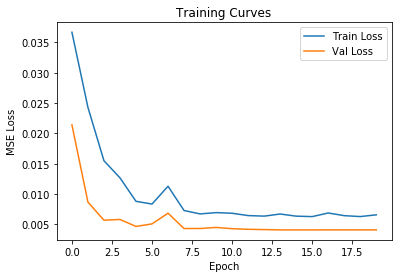

INFO:root:[MODEL]: Building model...
INFO:root:[MODEL]: Training started


Epoch 1/40
101/102 [============================>.] - ETA: 0s - loss: 0.1660
Epoch 00001: val_loss improved from inf to 0.03433, saving model to saved_models\25042021-022350-e40.h5
102/102 [==============================] - 4s 38ms/step - loss: 0.1658 - val_loss: 0.0343
Epoch 2/40
102/102 [==============================] - ETA: 0s - loss: 0.0853
Epoch 00002: val_loss improved from 0.03433 to 0.02527, saving model to saved_models\25042021-022350-e40.h5
102/102 [==============================] - 3s 34ms/step - loss: 0.0853 - val_loss: 0.0253
Epoch 3/40
102/102 [==============================] - ETA: 0s - loss: 0.0616
Epoch 00003: val_loss improved from 0.02527 to 0.01702, saving model to saved_models\25042021-022350-e40.h5
102/102 [==============================] - 3s 33ms/step - loss: 0.0616 - val_loss: 0.0170
Epoch 4/40
101/102 [============================>.] - ETA: 0s - loss: 0.0527
Epoch 00004: val_loss improved from 0.01702 to 0.01156, saving model to saved_models\25042021-022350-e

INFO:root:Model training completed. Model saved to saved_models\25042021-022350-e40.h5


Epoch 00027: early stopping


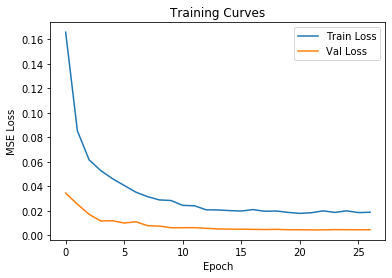

INFO:root:[MODEL]: Building model...
INFO:root:[MODEL]: Training started


Epoch 1/40
102/102 [==============================] - ETA: 0s - loss: 0.0727 - mae: 0.1683
Epoch 00001: val_loss improved from inf to 0.02659, saving model to saved_models\25042021-022531-e40.h5
102/102 [==============================] - 2s 15ms/step - loss: 0.0727 - mae: 0.1683 - val_loss: 0.0266 - val_mae: 0.1259
Epoch 2/40
102/102 [==============================] - ETA: 0s - loss: 0.0358 - mae: 0.1276
Epoch 00002: val_loss improved from 0.02659 to 0.01772, saving model to saved_models\25042021-022531-e40.h5
102/102 [==============================] - 1s 9ms/step - loss: 0.0358 - mae: 0.1276 - val_loss: 0.0177 - val_mae: 0.0994
Epoch 3/40
 97/102 [===========================>..] - ETA: 0s - loss: 0.0189 - mae: 0.0938
Epoch 00003: val_loss improved from 0.01772 to 0.01215, saving model to saved_models\25042021-022531-e40.h5
102/102 [==============================] - 1s 8ms/step - loss: 0.0187 - mae: 0.0933 - val_loss: 0.0122 - val_mae: 0.0812
Epoch 4/40
 95/102 [=======================

INFO:root:Model training completed. Model saved to saved_models\25042021-022531-e40.h5


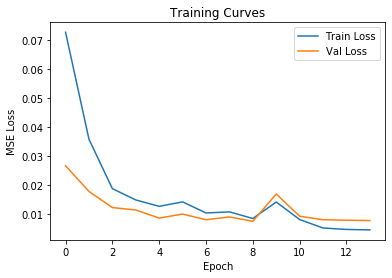

In [12]:
#train models
x,y = load_data()
LSTM = train_model('LSTM',x,y)
RNN= train_model('RNN',x,y)
WaveNet= train_model('WaveNet',x,y)

INFO:root:Loading model from saved_models/23042021-222604-e40.h5


INFO:root:[MODEL]: Predicting Point-by-Point...


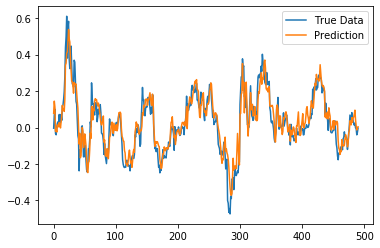

The root mean squared error of the model prediciton is 0.0613534148255161
System CAGR: 52.2%
System Sharpe: 1.2
Market CAGR: 19.9%
Market Sharpe: 0.6


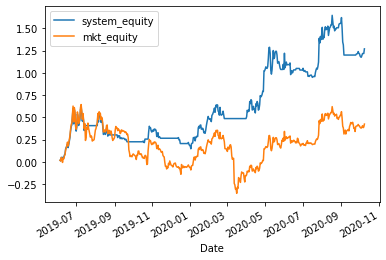

average return 0.003475
[-0.00432887  0.00432939]
p_value:
0.06020000000000003
Reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)


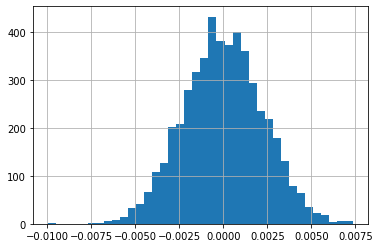

In [ ]:
#original datset
#load pretrained best performing model
LSTM_best = loading_model('23042021-222604-e40.h5')
LSTM_rmse, LSTM_CAGR, LSTM_Sharpe = predict_model(LSTM_best)

INFO:root:Loading model from saved_models/21042021-192848-e40.h5
INFO:root:[MODEL]: Predicting Point-by-Point...


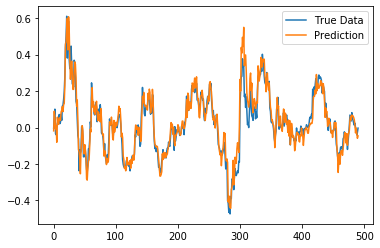

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


The root mean squared error of the model prediciton is 0.0538772155326343
System CAGR: 47.2%
System Sharpe: 1.2
Market CAGR: 19.9%
Market Sharpe: 0.6


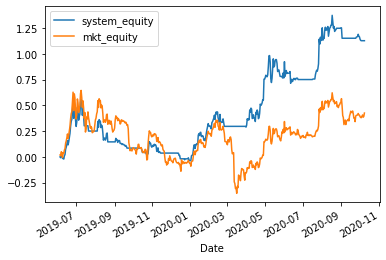

average return 0.003809
[-0.00427809  0.00434287]
p_value:
0.042200000000000015
Reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)


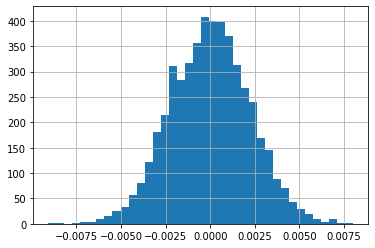

In [ ]:
#original datset
#load pretrained best performing model
RNN_best= loading_model('21042021-192848-e40.h5')
RNN_rmse, RNN_CAGR, RNN_Sharpe = predict_model(RNN_best)

INFO:root:Loading model from saved_models/21042021-222836-e40.h5
INFO:root:[MODEL]: Predicting Point-by-Point...


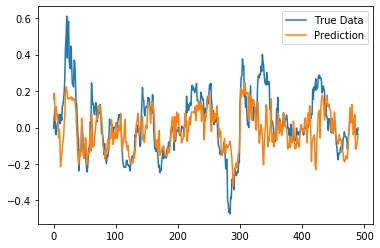

The root mean squared error of the model prediciton is 0.1294460410113715
System CAGR: 69.6%
System Sharpe: 1.6
Market CAGR: 19.9%
Market Sharpe: 0.6


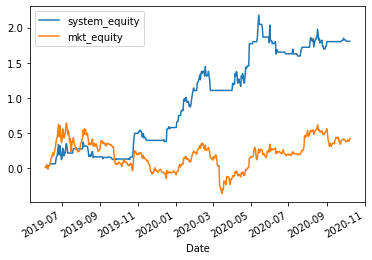

average return 0.003402
[-0.00411493  0.00416308]
p_value:
0.05700000000000005
Reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)


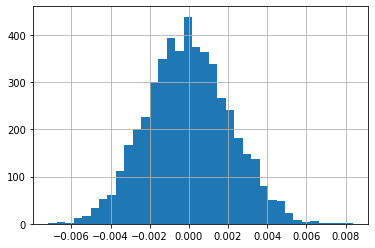

In [ ]:
#original dataset
#load pretrained best performing model
WaveNet_best= loading_model('21042021-222836-e40.h5')
WaveNet_rmse, WaveNet_CAGR, WaveNet_Sharpe = predict_model(WaveNet_best)

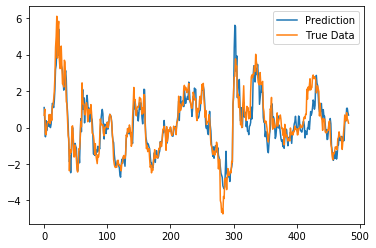

rmse: 0.6416282639650345


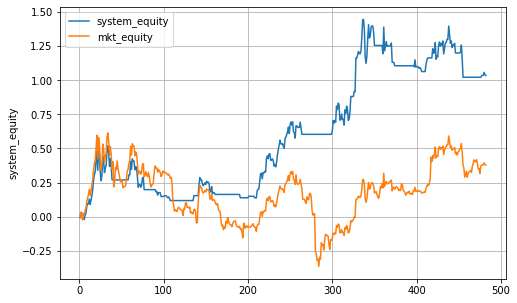

system_cagr:  482    44.89131
Name: system_equity, dtype: float64
system_sharpe:  0.9594080599920846
mkt_cagr:  482    18.246768
Name: mkt_equity, dtype: float64
mkt_sharpe:  0.2841725385837663
average return 0.004552
[-0.00417957  0.00426088]
p_value:
0.01759999999999995
Reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)


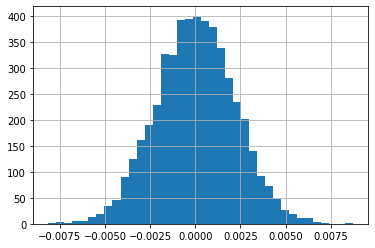

In [ ]:
#load,test Sequence2Sequence LSTM model on original dataset
system_returns, system_sharpe =s2s.sequence_to_sequence('LSTM','btc_dataset.csv',0.64,0.2,True, 'LSTM-seq2seq-best_20_4_original.hdf5')

Epoch 1/40
 95/103 [==========================>...] - ETA: 0s - loss: 4.3246 - last_time_step_mse: 11.6571
Epoch 00001: val_loss improved from inf to 0.90150, saving model to LSTM-weights-best.hdf5
103/103 [==============================] - 1s 11ms/step - loss: 4.1937 - last_time_step_mse: 11.4047 - val_loss: 0.9015 - val_last_time_step_mse: 1.9230
Epoch 2/40
102/103 [============================>.] - ETA: 0s - loss: 2.7428 - last_time_step_mse: 8.1040
Epoch 00002: val_loss improved from 0.90150 to 0.77791, saving model to LSTM-weights-best.hdf5
103/103 [==============================] - 1s 6ms/step - loss: 2.7379 - last_time_step_mse: 8.0856 - val_loss: 0.7779 - val_last_time_step_mse: 1.5574
Epoch 3/40
 93/103 [==========================>...] - ETA: 0s - loss: 2.4404 - last_time_step_mse: 7.5449
Epoch 00003: val_loss improved from 0.77791 to 0.76629, saving model to LSTM-weights-best.hdf5
103/103 [==============================] - 1s 6ms/step - loss: 2.3733 - last_time_step_mse: 7.16

Epoch 25/40
 95/103 [==========================>...] - ETA: 0s - loss: 1.5582 - last_time_step_mse: 4.6038
Epoch 00025: val_loss did not improve from 0.62682
103/103 [==============================] - 1s 6ms/step - loss: 1.5996 - last_time_step_mse: 4.7376 - val_loss: 0.6270 - val_last_time_step_mse: 1.3327
Epoch 26/40
 98/103 [===========================>..] - ETA: 0s - loss: 1.5881 - last_time_step_mse: 4.6096
Epoch 00026: val_loss improved from 0.62682 to 0.62571, saving model to LSTM-weights-best.hdf5
103/103 [==============================] - 1s 7ms/step - loss: 1.5899 - last_time_step_mse: 4.6857 - val_loss: 0.6257 - val_last_time_step_mse: 1.3387
Epoch 27/40
 95/103 [==========================>...] - ETA: 0s - loss: 1.5680 - last_time_step_mse: 4.6792
Epoch 00027: val_loss improved from 0.62571 to 0.62556, saving model to LSTM-weights-best.hdf5
103/103 [==============================] - 1s 6ms/step - loss: 1.5928 - last_time_step_mse: 4.7229 - val_loss: 0.6256 - val_last_time_st

<Figure size 432x288 with 0 Axes>

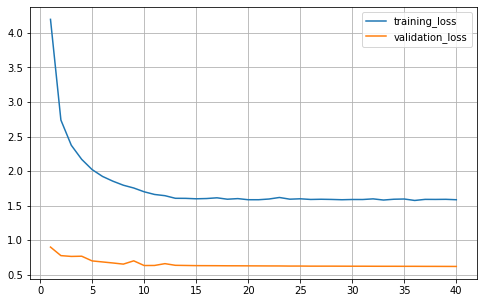

val_loss_value:  0.6214003562927246


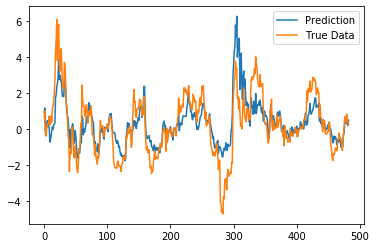

rmse: 1.0339614962208268


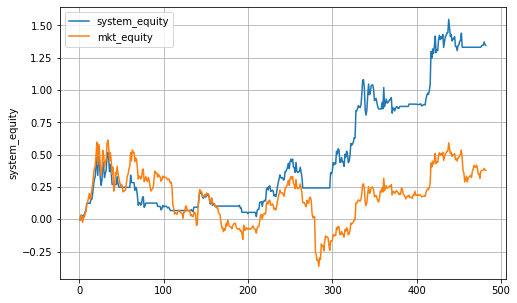

system_cagr:  482    56.040609
Name: system_equity, dtype: float64
system_sharpe:  1.0984356358764253
mkt_cagr:  482    18.246768
Name: mkt_equity, dtype: float64
mkt_sharpe:  0.2841725385837663
average return 0.005519
[-0.00453726  0.0048981 ]
p_value:
0.014000000000000012
Reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)


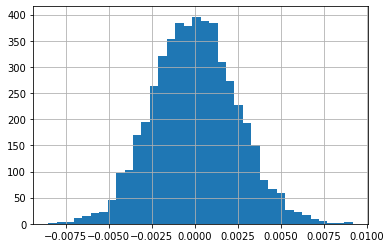

In [ ]:
#load,test Sequence2Sequence GRU model on original dataset
system_returns, system_sharpe =s2s.sequence_to_sequence('GRU','btc_dataset.csv',0.64,0.2,False, '')

# 2017-2020 data without additional feature
Select the subset of the original Bitcoin dataset from Dec.13, 2017 to Oct.9, 2020, with original 16 columns of features

This date range subset is created and evaluated, to make sure the date range is consistent with the COT data. The COT data includes options future data for BitCoin starting Dec.13, 2017. 

For 2017-2020 dataset, the splitting of training, validation and test set are adjusted to 40%, 20%, and 40% respectively. The bigger testset is intended to test the robustness of the model, as well as including market crash event on both trainingset and testset.

The results below served as a baseline to compared with next batch of results on dataset with additional features


In [8]:
#configure to the 2017-2020 subset of original dataset
with open("config_2017.json", "r") as f:
    configs = json.load(f)
logging.info(f"Successfully loaded configuration file!")
print('dataset in this configuration : ', configs['data']['filename'])
print('test set ratio in this configuration : ', 1- configs['data']['train_test_split'])
print('number of features in this configuration : ', len( configs['data']['columns']))

INFO:root:Successfully loaded configuration file!


dataset in this configuration :  btc_dataset_2017-2020.csv
test set ratio in this configuration :  0.4
number of features in this configuration :  16


INFO:root:[MODEL]: Building model...


The shape of training features are :  (590, 20, 16)


INFO:root:Model Building complete in 0.0 min and 0.2 s
INFO:root:[MODEL]: Training started


Epoch 1/40
25/25 [==============================] - ETA: 0s - loss: 0.0218
Epoch 00001: val_loss improved from inf to 0.03235, saving model to saved_models\25042021-021707-e40.h5
25/25 [==============================] - 4s 150ms/step - loss: 0.0218 - val_loss: 0.0324
Epoch 2/40
25/25 [==============================] - ETA: 0s - loss: 0.0114
Epoch 00002: val_loss improved from 0.03235 to 0.02288, saving model to saved_models\25042021-021707-e40.h5
25/25 [==============================] - 3s 133ms/step - loss: 0.0114 - val_loss: 0.0229
Epoch 3/40
25/25 [==============================] - ETA: 0s - loss: 0.0092
Epoch 00003: val_loss improved from 0.02288 to 0.01210, saving model to saved_models\25042021-021707-e40.h5
25/25 [==============================] - 3s 134ms/step - loss: 0.0092 - val_loss: 0.0121
Epoch 4/40
25/25 [==============================] - ETA: 0s - loss: 0.0070
Epoch 00004: val_loss did not improve from 0.01210
25/25 [==============================] - 3s 128ms/step - loss:

INFO:root:Model training completed. Model saved to saved_models\25042021-021707-e40.h5


Epoch 00008: early stopping


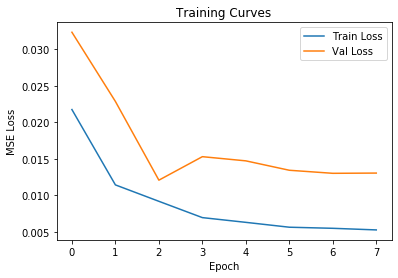

INFO:root:[MODEL]: Building model...
INFO:root:[MODEL]: Training started


Epoch 1/40
25/25 [==============================] - ETA: 0s - loss: 0.1845
Epoch 00001: val_loss improved from inf to 0.08029, saving model to saved_models\25042021-021738-e40.h5
25/25 [==============================] - 1s 41ms/step - loss: 0.1845 - val_loss: 0.0803
Epoch 2/40
25/25 [==============================] - ETA: 0s - loss: 0.1026
Epoch 00002: val_loss improved from 0.08029 to 0.03909, saving model to saved_models\25042021-021738-e40.h5
25/25 [==============================] - 1s 36ms/step - loss: 0.1026 - val_loss: 0.0391
Epoch 3/40
25/25 [==============================] - ETA: 0s - loss: 0.0986
Epoch 00003: val_loss improved from 0.03909 to 0.03115, saving model to saved_models\25042021-021738-e40.h5
25/25 [==============================] - 1s 36ms/step - loss: 0.0986 - val_loss: 0.0311
Epoch 4/40
24/25 [===========================>..] - ETA: 0s - loss: 0.0676
Epoch 00004: val_loss improved from 0.03115 to 0.02798, saving model to saved_models\25042021-021738-e40.h5
25/25 [=

INFO:root:Model training completed. Model saved to saved_models\25042021-021738-e40.h5


Epoch 00013: early stopping


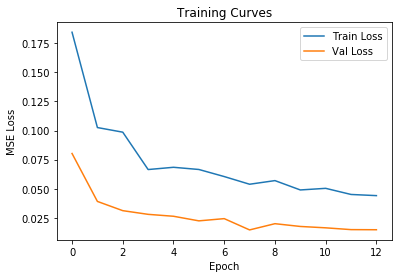

INFO:root:[MODEL]: Building model...
INFO:root:[MODEL]: Training started


Epoch 1/40
25/25 [==============================] - ETA: 0s - loss: 0.0309 - mae: 0.1388
Epoch 00001: val_loss improved from inf to 0.06639, saving model to saved_models\25042021-021751-e40.h5
25/25 [==============================] - 1s 32ms/step - loss: 0.0309 - mae: 0.1388 - val_loss: 0.0664 - val_mae: 0.2016
Epoch 2/40
20/25 [=======================>......] - ETA: 0s - loss: 0.0307 - mae: 0.1383
Epoch 00002: val_loss improved from 0.06639 to 0.06540, saving model to saved_models\25042021-021751-e40.h5
25/25 [==============================] - 0s 11ms/step - loss: 0.0301 - mae: 0.1358 - val_loss: 0.0654 - val_mae: 0.1997
Epoch 3/40
17/25 [===================>..........] - ETA: 0s - loss: 0.0259 - mae: 0.1257
Epoch 00003: val_loss improved from 0.06540 to 0.05363, saving model to saved_models\25042021-021751-e40.h5
25/25 [==============================] - 0s 12ms/step - loss: 0.0246 - mae: 0.1230 - val_loss: 0.0536 - val_mae: 0.1636
Epoch 4/40
17/25 [===================>..........] - E

INFO:root:Model training completed. Model saved to saved_models\25042021-021751-e40.h5


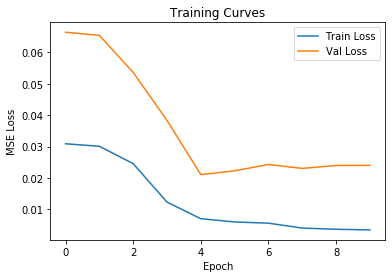

In [9]:
#Train models on 2017 subset
x,y = load_data()
LSTM= train_model('LSTM',x,y)
RNN= train_model('RNN',x,y)
WaveNet= train_model('WaveNet',x,y)

INFO:root:[MODEL]: Predicting Point-by-Point...


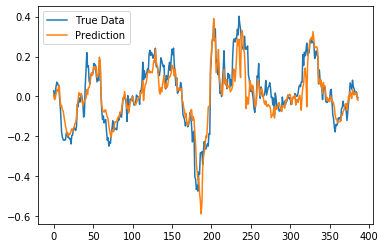

The root mean squared error of the model prediciton is 0.07196705334643262
System CAGR: 48.3%
System Sharpe: 1.4
Market CAGR: 2.9%
Market Sharpe: 0.3


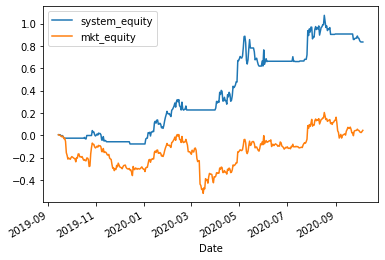

average return 0.004463
[-0.00453123  0.00474409]
p_value:
0.032200000000000006
Reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)


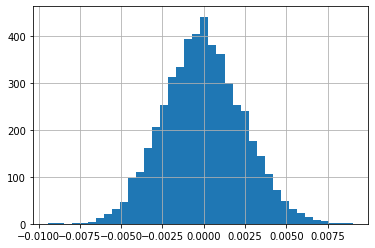

In [ ]:
#2017
LSTM_rmse, LSTM_CAGR, LSTM_Sharpe = predict_model(LSTM)

INFO:root:[MODEL]: Predicting Point-by-Point...


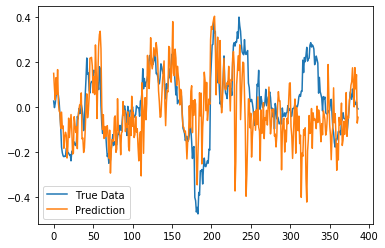

The root mean squared error of the model prediciton is 0.16452166117408545
System CAGR: 13.5%
System Sharpe: 0.5
Market CAGR: 2.9%
Market Sharpe: 0.3


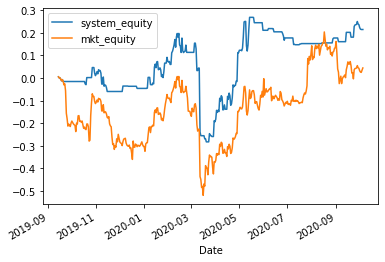

average return 0.003506
[-0.00645428  0.00840985]
p_value:
0.17579999999999996
Do not reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)


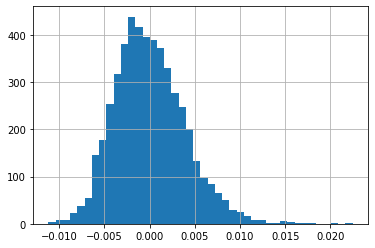

In [ ]:
#2017
RNN_rmse, RNN_CAGR, RNN_Sharpe = predict_model(RNN)

INFO:root:Loading model from saved_models/23042021-215304-e40.h5


INFO:root:[MODEL]: Predicting Point-by-Point...


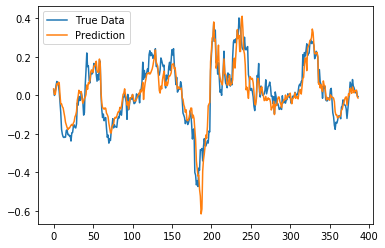

The root mean squared error of the model prediciton is 0.06569761742928615
System CAGR: 62.7%
System Sharpe: 1.6
Market CAGR: 2.9%
Market Sharpe: 0.3


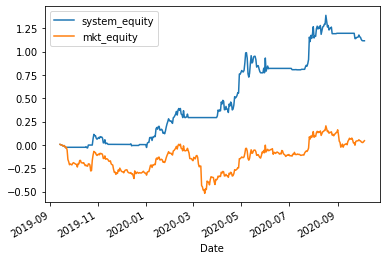

average return 0.004824
[-0.00461186  0.00477913]
p_value:
0.023399999999999976
Reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)


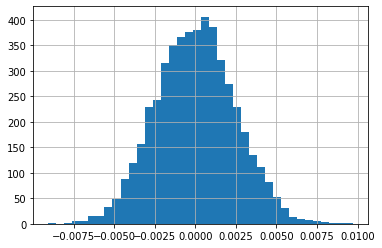

In [ ]:
#2017
WaveNet_best =  loading_model('23042021-215304-e40.h5')
WaveNet_rmse, WaveNet_CAGR, WaveNet_Sharpe = predict_model(WaveNet_best)

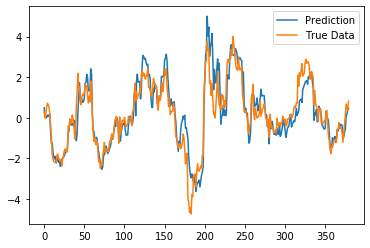

rmse: 0.6953312017353065


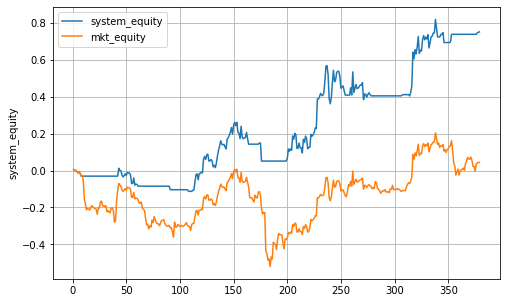

system_cagr:  379    44.984732
Name: system_equity, dtype: float64
system_sharpe:  1.1062776174298365
mkt_cagr:  379    2.894727
Name: mkt_equity, dtype: float64
mkt_sharpe:  0.05028263437311741
average return 0.003899
[-0.00473423  0.00511976]
p_value:
0.062000000000000055
Reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)


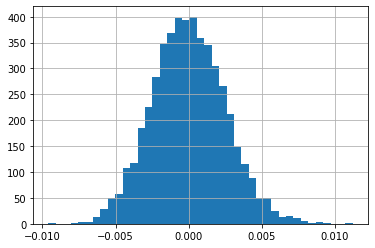

In [ ]:
# load and test sequence to sequence LSTM model on 2017-2020 subset
system_returns, system_sharpe =s2s.sequence_to_sequence('LSTM','btc_dataset_2017-2020.csv',0.4,0.4,True, 'LSTM-seq2seq-best_20_4_2017-2020.hdf5')

Epoch 1/40
23/26 [=========================>....] - ETA: 0s - loss: 1.9919 - last_time_step_mse: 3.3525
Epoch 00001: val_loss improved from inf to 2.45214, saving model to LSTM-weights-best.hdf5
26/26 [==============================] - 1s 27ms/step - loss: 1.9330 - last_time_step_mse: 3.2446 - val_loss: 2.4521 - val_last_time_step_mse: 5.0446
Epoch 2/40
20/26 [======================>.......] - ETA: 0s - loss: 1.5293 - last_time_step_mse: 2.5924
Epoch 00002: val_loss improved from 2.45214 to 2.06910, saving model to LSTM-weights-best.hdf5
26/26 [==============================] - 0s 9ms/step - loss: 1.4419 - last_time_step_mse: 2.5261 - val_loss: 2.0691 - val_last_time_step_mse: 4.4823
Epoch 3/40
22/26 [========================>.....] - ETA: 0s - loss: 1.0093 - last_time_step_mse: 1.7590
Epoch 00003: val_loss improved from 2.06910 to 1.63736, saving model to LSTM-weights-best.hdf5
26/26 [==============================] - 0s 8ms/step - loss: 1.0008 - last_time_step_mse: 1.7875 - val_loss:

Epoch 25/40
23/26 [=========================>....] - ETA: 0s - loss: 0.5929 - last_time_step_mse: 1.0305
Epoch 00025: val_loss did not improve from 0.93027
26/26 [==============================] - 0s 6ms/step - loss: 0.5931 - last_time_step_mse: 1.0228 - val_loss: 0.9359 - val_last_time_step_mse: 2.2502
Epoch 00025: early stopping


<Figure size 432x288 with 0 Axes>

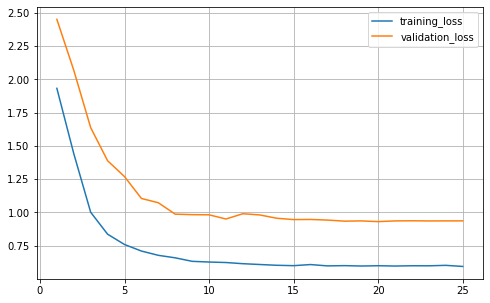

val_loss_value:  0.9359365105628967


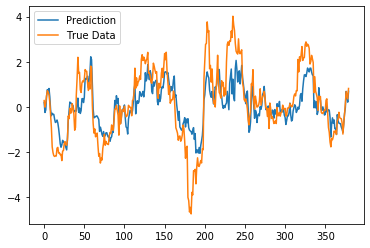

rmse: 0.9750854635143018


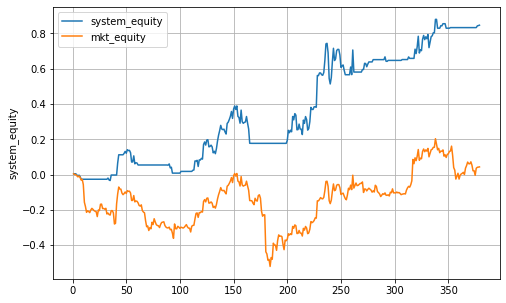

system_cagr:  379    50.20308
Name: system_equity, dtype: float64
system_sharpe:  1.29478425375358
mkt_cagr:  379    2.894727
Name: mkt_equity, dtype: float64
mkt_sharpe:  0.05028263437311741
average return 0.003977
[-0.00450212  0.00476465]
p_value:
0.05359999999999998
Reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)


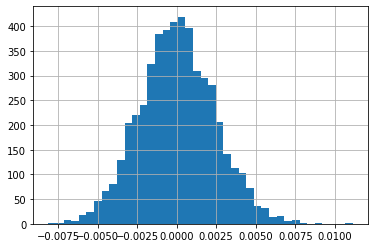

In [ ]:
#load,test Sequence2Sequence GRU model on original data subset 2017-2020
system_returns, system_sharpe =s2s.sequence_to_sequence('GRU','btc_dataset_2017-2020.csv',0.4,0.4,False, 'LSTM-seq2seq-best_20_4_original.hdf5')

# Add COT and QQQ Data
Added 5 features from commitment of traders (COT) data to the original dataset, see https://www.cftc.gov/MarketReports/CommitmentsofTraders/HistoricalCompressed/index.htm for detail data.

Also added 3 related stock data: QQQ, FINX, and RIOT, downloaded from WRDS databse, see https://wrds-www.wharton.upenn.edu/.

Our code for data cleaning and pre-processing of these 8 features is saved as add_COT_QQQ.ipynb, in the data folder.

In [13]:
with open("config_COT_QQQ.json", "r") as f:
    configs = json.load(f)
logging.info(f"Successfully loaded configuration file!")
print('dataset in this configuration : ', configs['data']['filename'])
print('test set ratio in this configuration : ', 1- configs['data']['train_test_split'])
print('number of features in this configuration : ', len( configs['data']['columns']))

INFO:root:Successfully loaded configuration file!


dataset in this configuration :  btc_dataset_COTQQQ.csv
test set ratio in this configuration :  0.4
number of features in this configuration :  24


INFO:root:[MODEL]: Building model...


The shape of training features are :  (624, 20, 24)


INFO:root:Model Building complete in 0.0 min and 0.2 s
INFO:root:[MODEL]: Training started


Epoch 1/40
27/27 [==============================] - ETA: 0s - loss: 0.0178
Epoch 00001: val_loss improved from inf to 0.02049, saving model to saved_models\25042021-022545-e40.h5
27/27 [==============================] - 4s 151ms/step - loss: 0.0178 - val_loss: 0.0205
Epoch 2/40
27/27 [==============================] - ETA: 0s - loss: 0.0099
Epoch 00002: val_loss did not improve from 0.02049
27/27 [==============================] - 3s 128ms/step - loss: 0.0099 - val_loss: 0.0250
Epoch 3/40
27/27 [==============================] - ETA: 0s - loss: 0.0067
Epoch 00003: val_loss did not improve from 0.02049

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
27/27 [==============================] - 3s 121ms/step - loss: 0.0067 - val_loss: 0.0243
Epoch 4/40
27/27 [==============================] - ETA: 0s - loss: 0.0056
Epoch 00004: val_loss improved from 0.02049 to 0.01635, saving model to saved_models\25042021-022545-e40.h5
27/27 [==============================

INFO:root:Model training completed. Model saved to saved_models\25042021-022545-e40.h5


Epoch 00017: early stopping


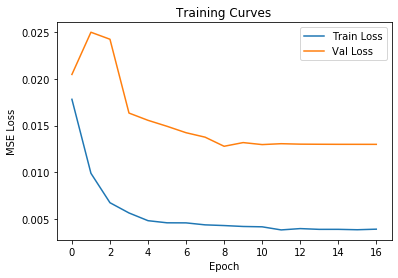

INFO:root:[MODEL]: Building model...
INFO:root:[MODEL]: Training started


Epoch 1/40
27/27 [==============================] - ETA: 0s - loss: 0.2215
Epoch 00001: val_loss improved from inf to 0.08713, saving model to saved_models\25042021-022648-e40.h5
27/27 [==============================] - 1s 43ms/step - loss: 0.2215 - val_loss: 0.0871
Epoch 2/40
27/27 [==============================] - ETA: 0s - loss: 0.1503
Epoch 00002: val_loss improved from 0.08713 to 0.06128, saving model to saved_models\25042021-022648-e40.h5
27/27 [==============================] - 1s 34ms/step - loss: 0.1503 - val_loss: 0.0613
Epoch 3/40
27/27 [==============================] - ETA: 0s - loss: 0.1124
Epoch 00003: val_loss improved from 0.06128 to 0.06039, saving model to saved_models\25042021-022648-e40.h5
27/27 [==============================] - 1s 33ms/step - loss: 0.1124 - val_loss: 0.0604
Epoch 4/40
27/27 [==============================] - ETA: 0s - loss: 0.1216
Epoch 00004: val_loss did not improve from 0.06039
27/27 [==============================] - 1s 31ms/step - loss: 0.1

INFO:root:Model training completed. Model saved to saved_models\25042021-022648-e40.h5


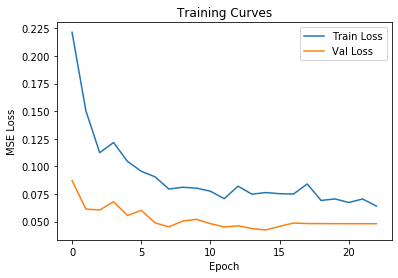

INFO:root:[MODEL]: Building model...
INFO:root:[MODEL]: Training started


Epoch 1/40
27/27 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.1372
Epoch 00001: val_loss improved from inf to 0.05376, saving model to saved_models\25042021-022711-e40.h5
27/27 [==============================] - 1s 23ms/step - loss: 0.0301 - mae: 0.1372 - val_loss: 0.0538 - val_mae: 0.1709
Epoch 2/40
18/27 [===================>..........] - ETA: 0s - loss: 0.0303 - mae: 0.1387
Epoch 00002: val_loss did not improve from 0.05376
27/27 [==============================] - 0s 8ms/step - loss: 0.0293 - mae: 0.1365 - val_loss: 0.0665 - val_mae: 0.1983
Epoch 3/40
27/27 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.1358
Epoch 00003: val_loss did not improve from 0.05376

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
27/27 [==============================] - 0s 8ms/step - loss: 0.0294 - mae: 0.1358 - val_loss: 0.0574 - val_mae: 0.1793
Epoch 4/40
27/27 [==============================] - ETA: 0s - loss: 0.0282 - mae: 0.133

INFO:root:Model training completed. Model saved to saved_models\25042021-022711-e40.h5


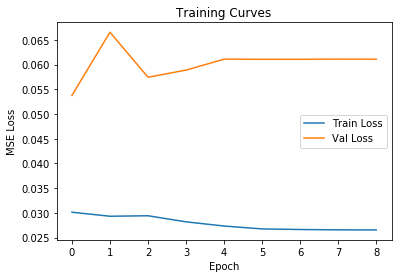

In [14]:
# train models on augmented dataset
x,y = load_data()
LSTM= train_model('LSTM',x,y)
RNN= train_model('RNN',x,y)
WaveNet= train_model('WaveNet',x,y)

INFO:root:[MODEL]: Predicting Point-by-Point...


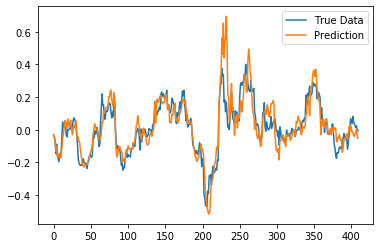

The root mean squared error of the model prediciton is 0.08291449152999684
System CAGR: 38.4%
System Sharpe: 1.1
Market CAGR: 4.2%
Market Sharpe: 0.4


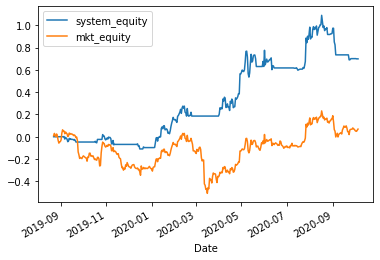

average return 0.002768
[-0.0044146   0.00456323]
p_value:
0.11599999999999999
Do not reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)


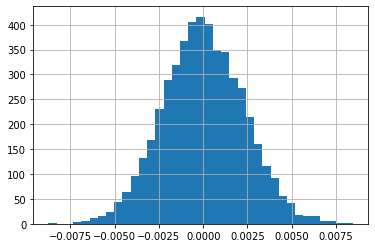

In [ ]:
#COTQQQ data
LSTM_rmse, LSTM_CAGR, LSTM_Sharpe = predict_model(LSTM)

INFO:root:[MODEL]: Predicting Point-by-Point...


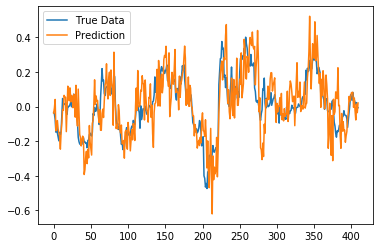

The root mean squared error of the model prediciton is 0.118474219464945
System CAGR: 32.4%
System Sharpe: 1.0
Market CAGR: 4.2%
Market Sharpe: 0.4


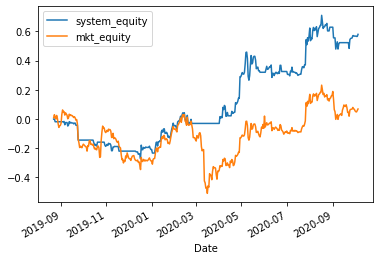

average return 0.002041
[-0.00429943  0.0041488 ]
p_value:
0.16620000000000001
Do not reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)


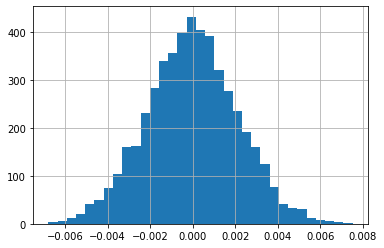

In [ ]:
#COTQQQ data
RNN_rmse, RNN_CAGR, RNN_Sharpe = predict_model(RNN)

INFO:root:Loading model from saved_models/23042021-015407-e40.h5
INFO:root:[MODEL]: Predicting Point-by-Point...


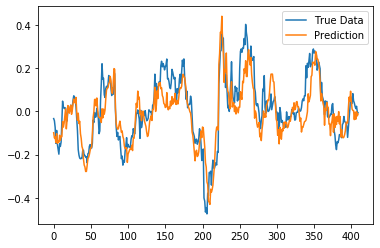

The root mean squared error of the model prediciton is 0.08369822628002137
System CAGR: 51.9%
System Sharpe: 1.5
Market CAGR: 4.2%
Market Sharpe: 0.4


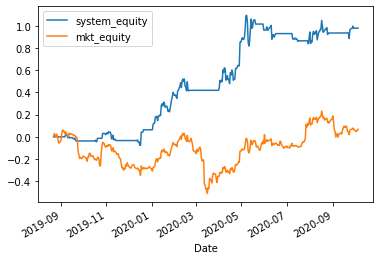

average return 0.002589
[-0.00411155  0.0042458 ]
p_value:
0.10499999999999998
Do not reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)


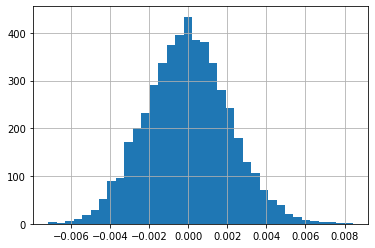

In [ ]:
#COTQQQ data
WaveNet_best= loading_model('23042021-015407-e40.h5')
WaveNet_rmse, WaveNet_CAGR, WaveNet_Sharpe = predict_model(WaveNet_best)

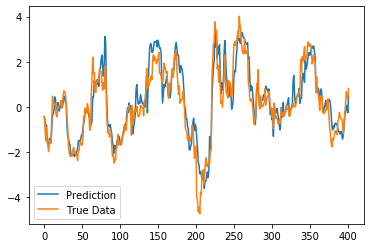

rmse: 0.6542912281694119


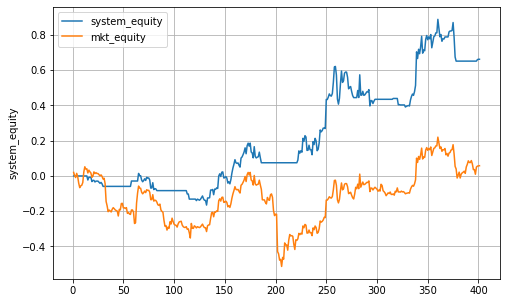

system_cagr:  401    37.509603
Name: system_equity, dtype: float64
system_sharpe:  0.9583270972240376
mkt_cagr:  401    3.608561
Name: mkt_equity, dtype: float64
mkt_sharpe:  0.06352316436601817
average return 0.003560
[-0.00461418  0.0048577 ]
p_value:
0.07120000000000004
Reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)


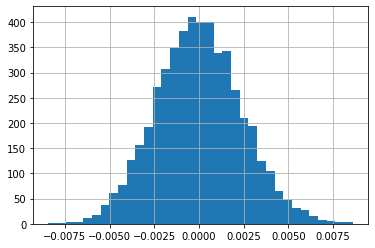

In [ ]:
#Load pre-trained Seq2Seq model and test on COTQQQ dataset
system_returns, system_sharpe =s2s.sequence_to_sequence('LSTM','btc_dataset_COTQQQ.csv',0.4,0.4,True, 'LSTM-seq2seq-best_20_4_COTQQQ.hdf5')

Epoch 1/40
27/27 [==============================] - ETA: 0s - loss: 1.8853 - last_time_step_mse: 3.1933
Epoch 00001: val_loss improved from inf to 2.44570, saving model to LSTM-weights-best.hdf5
27/27 [==============================] - 1s 29ms/step - loss: 1.8853 - last_time_step_mse: 3.1933 - val_loss: 2.4457 - val_last_time_step_mse: 4.9195
Epoch 2/40
21/27 [======================>.......] - ETA: 0s - loss: 1.3884 - last_time_step_mse: 2.4264
Epoch 00002: val_loss improved from 2.44570 to 2.28718, saving model to LSTM-weights-best.hdf5
27/27 [==============================] - 0s 8ms/step - loss: 1.4872 - last_time_step_mse: 2.5934 - val_loss: 2.2872 - val_last_time_step_mse: 4.7836
Epoch 3/40
21/27 [======================>.......] - ETA: 0s - loss: 1.1685 - last_time_step_mse: 2.0876
Epoch 00003: val_loss improved from 2.28718 to 1.93640, saving model to LSTM-weights-best.hdf5
27/27 [==============================] - 0s 8ms/step - loss: 1.1051 - last_time_step_mse: 2.0001 - val_loss:

<Figure size 432x288 with 0 Axes>

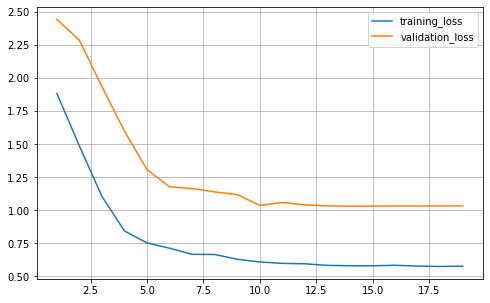

val_loss_value:  1.0339751243591309


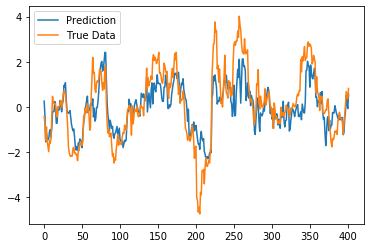

rmse: 0.9650900736539383


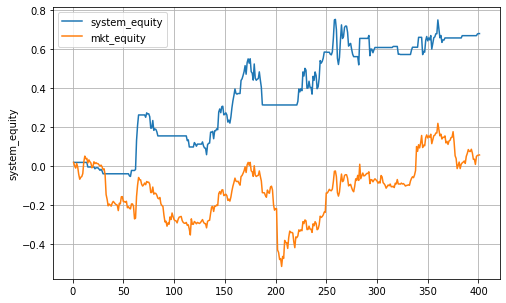

system_cagr:  401    38.453023
Name: system_equity, dtype: float64
system_sharpe:  1.0376773806905684
mkt_cagr:  401    3.608561
Name: mkt_equity, dtype: float64
mkt_sharpe:  0.06352316436601817
average return 0.003353
[-0.00431982  0.0043105 ]
p_value:
0.06440000000000001
Reject Null Hypothesis = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)


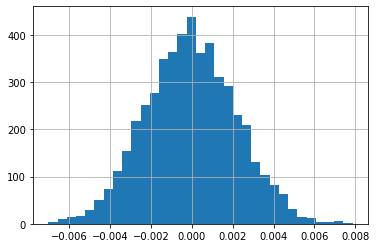

In [ ]:
#load,test Sequence2Sequence GRU model on augmented dataset
system_returns, system_sharpe =s2s.sequence_to_sequence('GRU','btc_dataset_COTQQQ.csv',0.4,0.4,False, 'LSTM-seq2seq-best_20_4_original.hdf5')

# Conclusion

**The final evaluation results for 5 deep learning models on 3 datasets are listed below.**

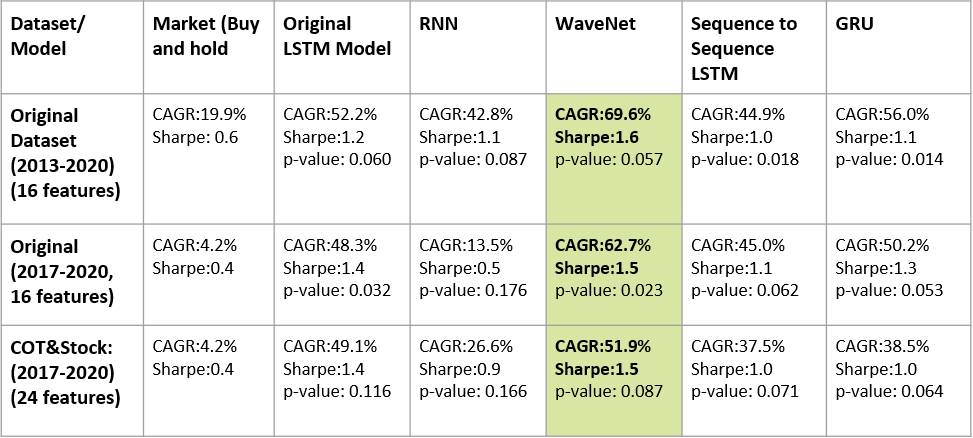

## Takeaway from the result
- The dataset size is limited by COT features which are only available after December 2017. The relative small size of dataset would directly affect the the quality of the mapping function approximated by neural networks and the model performance.
- RNN model performance is slightly worse than the original LSTM model on the original dataset. After adding COT&stock features, RNN model performance becomes even worse may due to the smaller dataset size.
- Seq-to-Seq models(LSTM & GRU) performances are always worse than the original LSTM model(Seq-to-Vector) before or after adding COT&stock features, however, Seq-to-Seq models perform better than RNN model(Seq-to-Vector) after adding COT&stock features
- WaveNet model performance always exceeds the original LSTM model before or after adding COT&stock features, may due to its capability of learning from very long sequence such as historical event years ago. **Thus our team chooses WaveNet to be the best model for Bitcoin prediction.**